In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [199]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-11-28 13:21:14,923 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-28 13:21:14,925 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-28 13:21:14,926 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [113]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

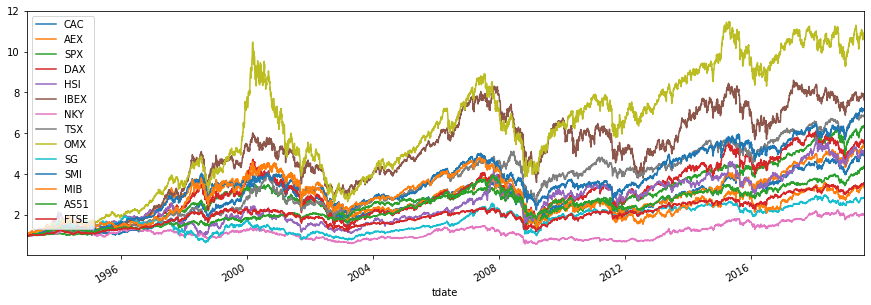

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

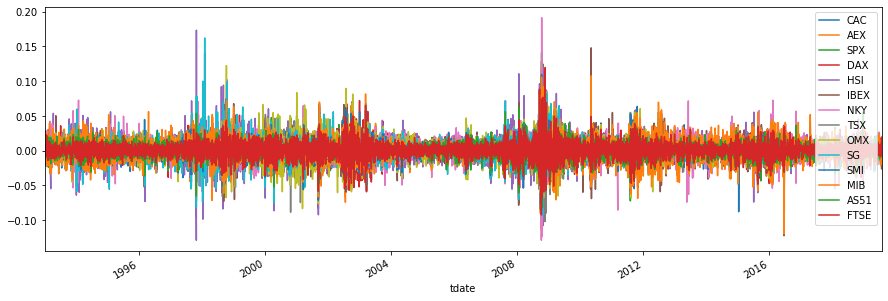

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

# CASE 0. 기존(머신러닝 사용 X)

In [10]:
from EPM import EPM

In [11]:
epm = EPM(strategy_name="EPM", asset_type="EQUITY")
epm.load_index_and_return(from_db=False, save_file=False)
epm.load_strategy_data(table='datastream', origin='EPS')
epm.set_rebalance_period(freq='month')  # rebalance_day: monday = 0, sunday = 6
epm.calculate_signal(minobs1=52, longlen=52, longlen2=13, shortlen=2, cs=0.35)
epm.set_portfolio_parameter(cs_strategy_type='notional')
epm.make_portfolio()

2019-11-28 13:21:19,190 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-28 13:21:19,190 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-28 13:21:19,191 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-28 13:21:19,191 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-28 13:21:19,192 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-28 13:21:19,192 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-28 13:21:21,204 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-28 13:21:21,204 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-28 13:21:21,205 - EPM - INFO - [STEP 3] CACULATE SIGNAL
2019-11-28 13:21:21,205 - EPM - INFO - [STEP 3] CACULATE SIGNAL
2019-11-28 13:21:21,206 - EPM - INFO - [STEP 3 - 1 - 1] SIGNAL 1. LONG TERM MOMENTUM
2019-11-28 13:21:21,206 - EPM - INFO - [STEP 3 - 1 - 1] SIGNAL 1. LONG TERM MOMENTUM
2019-11-28 13:21:21,243 - EPM - INFO - [STEP 3 - 1 - 2] SIGNAL 2. LONG TERM MOMENTUM - PERCENTAGE OF UP DAYS
2019-11-28 13:21:21,243 - EPM - INFO - [STEP 3 - 1 - 2] SIGNAL 

In [12]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
epm_comp_df = pd.read_csv('../check/past/epm.csv', header=0, index_col=0, parse_dates=True)
epm_lag_comp_df = pd.read_csv('../check/past/epm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [13]:
tester = Tester(epm)
tester.set_period(start=start_date, end=end_date)
tester.run()

2019-11-28 13:21:45,162 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-28 13:21:45,162 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-28 13:21:45,163 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-28 13:21:45,163 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-28 13:21:45,869 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-28 13:21:45,869 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [62]:
to_plot = (1.+ epm_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. REGRESSION

- INPUT을 시계열

In [64]:
indiv_momentum_lst = [21, 42, 63, 126, 252]

In [65]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

In [66]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

In [67]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [68]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':].reset_index()
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':].reset_index()
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':].reset_index()

In [72]:
asset_columns = df_index.columns

In [146]:
one_week = 5

df_y = df_index.stack().reset_index()
df_y.columns = ['tdate', 'ticker', 'y']

In [260]:
df_X_asset

y  avg_ret_21  avg_ret_42  avg_ret_63  avg_ret_126  avg_ret_252  \
0     1.284210    0.002583    0.001921    0.001272     0.001410     0.001132   
1     1.277519    0.002368    0.002354    0.001304     0.001344     0.001065   
2     1.265916    0.002211    0.002086    0.001086     0.001262     0.001006   
3     1.279492    0.002110    0.002081    0.001367     0.001347     0.001052   
4     1.298077    0.002593    0.002653    0.001683     0.001558     0.001148   
...        ...         ...         ...         ...          ...          ...   
6650  4.966787    0.000724    0.001392    0.000376     0.001167     0.000222   
6651  4.996181    0.001067    0.001876    0.000434     0.001186     0.000260   
6652  4.988165    0.000605    0.001712    0.000409     0.001130     0.000253   
6653  4.907552   -0.000419    0.001514    0.000245     0.001033     0.000252   
6654  4.907552   -0.000500    0.001351    0.000218     0.000901     0.000254   

      avg_vol_21  avg_vol_42  avg_vol_63  avg_vol_126  avg_vol_252  \
0       0.007659    0.009615    0.009047     0.009037     0.008702   
1       0.007817    0.008824    0.009020     0.009054     0.008685   
2       0.008019    0.008999    0.009103     0.009102     0.008704   
3       0.007891    0.008994    0.009123     0.009140     0.008725   
4       0.008335    0.009005    0.009229     0.009135     0.008739   
...          ...         ...         ...          ...          ...   
6650    0.004713    0.006432    0.007799     0.007133     0.008494   
6651    0.004821    0.005962    0.007826     0.007142     0.008498   
6652    0.004572    0.005961    0.007830     0.007136     0.008499   
6653    0.005722    0.006408    0.008068     0.007288     0.008501   
6654    0.005702    0.006356    0.008065     0.007153     0.008501   

      cum_ret_21  cum_ret_42  cum_ret_63  cum_ret_126  cum_ret_252  y_shift_1  \
0       0.055057    0.081881    0.080608     0.188176     0.317474        NaN   
1       0.050280    0.102016    0.082852     0.178332     0.295335   1.284210   
2       0.046809    0.089665    0.068021     0.166123     0.276350   1.277519   
3       0.044615    0.089449    0.087071     0.178629     0.291031   1.265916   
4       0.055165    0.115840    0.108852     0.210391     0.322532   1.279492   
...          ...         ...         ...          ...          ...        ...   
6650    0.015091    0.059270    0.022032     0.154690     0.048101   4.991727   
6651    0.022402    0.081107    0.025768     0.157330     0.058122   4.966787   
6652    0.012567    0.073702    0.024122     0.149260     0.056245   4.996181   
6653   -0.009083    0.064699    0.013502     0.135090     0.055966   4.988165   
6654   -0.010773    0.057465    0.011771     0.116549     0.056350   4.907552   

      y_shift_2  y_shift_3  y_shift_4  y_shift_5  
0           NaN        NaN        NaN        NaN  
1           NaN        NaN        NaN        NaN  
2      1.284210        NaN        NaN        NaN  
3      1.277519   1.284210        NaN        NaN  
4      1.265916   1.277519   1.284210        NaN  
...         ...        ...        ...        ...  
6650   5.003752   4.957879   4.943182   4.943182  
6651   4.991727   5.003752   4.957879   4.943182  
6652   4.966787   4.991727   5.003752   4.957879  
6653   4.996181   4.966787   4.991727   5.003752  
6654   4.988165   4.996181   4.966787   4.991727  

[6655 rows x 21 columns]

In [429]:
data = {}

for i, asset in enumerate(asset_columns):
    X = []
    y = []
    
    df_index_asset = df_y[df_y['ticker'] == asset]
    df_mom_avg_ret_asset = df_mom_avg_ret[df_mom_avg_ret['ticker'] == asset]
    df_mom_avg_vol_asset = df_mom_avg_vol[df_mom_avg_vol['ticker'] == asset]
    df_mom_cum_ret_asset = df_mom_cum_ret[df_mom_cum_ret['ticker'] == asset]
    
    df_asset = pd.merge(df_index_asset, df_mom_avg_ret_asset, on=['ticker', 'tdate'])
    df_asset = pd.merge(df_asset, df_mom_avg_vol_asset, on=['ticker', 'tdate'])
    df_asset = pd.merge(df_asset, df_mom_cum_ret_asset, on=['ticker', 'tdate'])
    
    df_y_asset = df_asset['y']
    df_X_asset = df_asset[df_asset.columns[2:]]
    df_X_asset['y_shift_1'] = df_X_asset['y'].shift(1)
    df_X_asset['y_shift_2'] = df_X_asset['y'].shift(2)
    df_X_asset['y_shift_3'] = df_X_asset['y'].shift(3)
    df_X_asset['y_shift_4'] = df_X_asset['y'].shift(4)
    df_X_asset['y_shift_5'] = df_X_asset['y'].shift(5)
    df_X_asset['y_shift_6'] = df_X_asset['y'].shift(6)
    df_X_asset['y_shift_7'] = df_X_asset['y'].shift(7)
    df_X_asset['y_shift_8'] = df_X_asset['y'].shift(8)
    df_X_asset['y_shift_9'] = df_X_asset['y'].shift(9)
    df_X_asset['y_shift_10'] = df_X_asset['y'].shift(10)
    df_X_asset['y_shift_15'] = df_X_asset['y'].shift(15)
    df_X_asset['y_shift_20'] = df_X_asset['y'].shift(20)

    df_X_asset = df_X_asset.fillna(method='bfill')
    
    for j in range(df_X_asset.shape[0]):
        if j < 19:
            continue
        if j + 5 >= df_X_asset.shape[0]:
            break

        X.append(df_X_asset.iloc[j-19:j+1].values)
        y.append(df_y_asset.iloc[j+5])
    
    train_size = df_asset.set_index('tdate')[:'2010'].shape[0]
    test_size = df_asset.set_index('tdate')[:'2018'].shape[0]
    
    train_X = np.array(X[:train_size]).reshape(-1, 20, df_X_asset.shape[1])
    train_y = np.array(y[:train_size]).reshape(-1, 1)

    test_X = np.array(X[train_size:]).reshape(-1, 20, df_X_asset.shape[1])
    test_y = np.array(y[train_size:]).reshape(-1, 1)
    
    model1 = Sequential()
    model1.add(LSTM(32, activation='relu', input_shape=(20, df_X_asset.shape[1], )))
    model1.add(Dropout(0.2))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(1, activation='linear'))
    model1.compile(optimizer=optimizers.Adam(lr=0.01), loss='mse')
   
    epoch = 100
    batch_size = 32
    
    hist = model1.fit(train_X, train_y,
                  batch_size=batch_size,
                  epochs=epoch,
                  shuffle=True)
    
    train_pred = model1.predict(train_X).flatten()
    test_pred = model1.predict(test_X).flatten()
    pred = np.concatenate([train_pred, test_pred], axis=0)

    df_y_asset = df_asset[['tdate', 'y']]
    df_y_asset['pred'] = np.nan
    df_y_asset = df_y_asset.iloc[19:-5]
    df_y_asset['pred'] = pred
    
    data[asset] = {'X': df_X_asset, 'y': df_y_asset}

Epoch 1/100
4420/4420 [==============================] - 58s 13ms/sample - loss: 1.5298
Epoch 2/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.3284
Epoch 3/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1559
Epoch 4/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.1370
Epoch 5/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.1241
Epoch 6/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.1273
Epoch 7/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.1024
Epoch 8/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0902
Epoch 9/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0838
Epoch 10/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0782
Epoch 11/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.1966
Epoch 12/100
4420/4420 [==========================

4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0961
Epoch 96/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0871
Epoch 97/100
4420/4420 [==============================] - ETA: 0s - loss: 0.098 - 5s 1ms/sample - loss: 0.0984
Epoch 98/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0897
Epoch 99/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0882
Epoch 100/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0915
Epoch 1/100
4420/4420 [==============================] - 59s 13ms/sample - loss: 7.0098
Epoch 2/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2893
Epoch 3/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2459
Epoch 4/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2068
Epoch 5/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1853
Epoch 6/100
4420/4420 [===========

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0532
Epoch 89/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0529
Epoch 90/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0460
Epoch 91/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0443
Epoch 92/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0534
Epoch 93/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0486
Epoch 94/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0478
Epoch 95/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0589
Epoch 96/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0533
Epoch 97/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0551
Epoch 98/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0483
Epoch 99/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0477
Epoch 82/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0423
Epoch 83/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0457
Epoch 84/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0479
Epoch 85/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0435
Epoch 86/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0468
Epoch 87/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0483
Epoch 88/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0489
Epoch 89/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0450
Epoch 90/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0421
Epoch 91/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0449
Epoch 92/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0848
Epoch 76/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0814
Epoch 77/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0849
Epoch 78/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0819
Epoch 79/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0875
Epoch 80/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0842
Epoch 81/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0787
Epoch 82/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0784
Epoch 83/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0796
Epoch 84/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0823
Epoch 85/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0896
Epoch 86/100
4420/4420 [==============================] 

4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0294
Epoch 70/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0252
Epoch 71/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0271
Epoch 72/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0283
Epoch 73/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0276
Epoch 74/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0279
Epoch 75/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0298
Epoch 76/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0265
Epoch 77/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0275
Epoch 78/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0264
Epoch 79/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0265
Epoch 80/100
4420/4420 [==============================] 

4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2334
Epoch 64/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2295
Epoch 65/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2412
Epoch 66/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2415
Epoch 67/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2367
Epoch 68/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2485
Epoch 69/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.2582
Epoch 70/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2244
Epoch 71/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2350
Epoch 72/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2309
Epoch 73/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.2429
Epoch 74/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0033
Epoch 57/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0033
Epoch 58/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0035
Epoch 59/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0035
Epoch 60/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0034
Epoch 61/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0038
Epoch 62/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0036
Epoch 63/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0033 0s - loss: 0.003
Epoch 64/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0034
Epoch 65/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0033
Epoch 66/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0035
Epoch 67/100
4420/4420 [===============

4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0685
Epoch 51/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0654
Epoch 52/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0703
Epoch 53/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0695
Epoch 54/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0683
Epoch 55/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0743
Epoch 56/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0657
Epoch 57/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0622
Epoch 58/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0626
Epoch 59/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0671
Epoch 60/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.0664
Epoch 61/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3736
Epoch 45/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3730
Epoch 46/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3785
Epoch 47/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.3683
Epoch 48/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3597
Epoch 49/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3675
Epoch 50/100
4420/4420 [==============================] - 5s 1ms/sample - loss: 0.4392
Epoch 51/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.4053
Epoch 52/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3512
Epoch 53/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3769
Epoch 54/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.3338
Epoch 55/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0105
Epoch 39/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0129
Epoch 40/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0124
Epoch 41/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0127
Epoch 42/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0101
Epoch 43/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0126
Epoch 44/100
4420/4420 [==============================] - 7s 2ms/sample - loss: 0.0130
Epoch 45/100
4420/4420 [==============================] - 7s 1ms/sample - loss: 0.0137
Epoch 46/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0113
Epoch 47/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0114
Epoch 48/100
4420/4420 [==============================] - 7s 1ms/sample - loss: 0.0157 2s - ETA: 1
Epoch 49/100
4420/4420 [====================

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1204
Epoch 33/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1269
Epoch 34/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1179
Epoch 35/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1127
Epoch 36/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1195
Epoch 37/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1088
Epoch 38/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1252
Epoch 39/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1148
Epoch 40/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1080
Epoch 41/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1127
Epoch 42/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.1103
Epoch 43/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0755
Epoch 27/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0702
Epoch 28/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0740
Epoch 29/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0716
Epoch 30/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0651
Epoch 31/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0619
Epoch 32/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0700
Epoch 33/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0653
Epoch 34/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0682
Epoch 35/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0789
Epoch 36/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0672
Epoch 37/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0375
Epoch 21/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0442
Epoch 22/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0378
Epoch 23/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0412
Epoch 24/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0381
Epoch 25/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0393
Epoch 26/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0369
Epoch 27/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0434
Epoch 28/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0454
Epoch 29/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0524
Epoch 30/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0514
Epoch 31/100
4420/4420 [==============================] 

4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0135
Epoch 15/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0118
Epoch 16/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0121
Epoch 17/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0114
Epoch 18/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0123
Epoch 19/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0115
Epoch 20/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0102
Epoch 21/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0110
Epoch 22/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0099
Epoch 23/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0101
Epoch 24/100
4420/4420 [==============================] - 6s 1ms/sample - loss: 0.0106
Epoch 25/100
4420/4420 [==============================] 

In [430]:
data.keys()

dict_keys(['CAC', 'AEX', 'SPX', 'DAX', 'HSI', 'IBEX', 'NKY', 'TSX', 'OMX', 'SG', 'SMI', 'MIB', 'AS51', 'FTSE'])

In [431]:
data['SMI']['y'].set_index('tdate').iplot()

In [432]:
for key, value in data.items():
    data[key]['y'].columns = ['tdate', 'y', key]

In [433]:
count = 0
for key, value in data.items():
    if count == 0:
        df_ts = data[key]['y'].copy()
        count = count + 1
    else:
        df_ts = pd.merge(df_ts, data[key]['y'][['tdate', key]], on=['tdate'])
        
del df_ts['y']
df_ts.columns.name = 'ticker'
df_ts = df_ts.set_index('tdate')

In [434]:
df_result = (df_ts / df_index).dropna()

In [435]:
df_result_total = df_result.pct_change(5)

In [436]:
df_index_sub = df_index.loc['1994':]
long = df_result_total.shape[1] / 10 * 7
short = df_result_total.shape[1] / 10 * 3

df_pred_rank = df_result_total.rank(axis=1)
df_pred_long = (df_result_total > long).astype(np.float32)
df_pred_short = (df_result_total < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [437]:
strategy.set_rebalance_period(freq='week')
tester = Tester(strategy)
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-11-29 18:30:35,866 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-29 18:30:35,866 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-29 18:30:35,870 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-29 18:30:35,870 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-29 18:30:35,878 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-29 18:30:35,878 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-29 18:30:35,881 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-29 18:30:35,881 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-29 18:30:50,098 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-29 18:30:50,098 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-29 18:30:50,102 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-29 18:30:50,102 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-29 18:30:51,753 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-11-29 18:30:51,753 - EPM - 

### TEST

In [438]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run()

2019-11-29 18:31:02,429 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-29 18:31:02,429 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-29 18:31:02,435 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-29 18:31:02,435 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-29 18:31:03,488 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-29 18:31:03,488 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [439]:
to_plot['TS_ML'] = tester1.strategy.TS_result

In [440]:
to_plot.iplot()

# CASE 2. Case1을 Rolling으로 실행

In [366]:
test_rolling_one_year = [
    '2010-12-31',
    '2011-12-31',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-31',
    '2017-12-31'
]

In [399]:
data = {}

for i, asset in enumerate(asset_columns):
    X = []
    y = []
    
    df_index_asset = df_y[df_y['ticker'] == asset]
    df_mom_avg_ret_asset = df_mom_avg_ret[df_mom_avg_ret['ticker'] == asset]
    df_mom_avg_vol_asset = df_mom_avg_vol[df_mom_avg_vol['ticker'] == asset]
    df_mom_cum_ret_asset = df_mom_cum_ret[df_mom_cum_ret['ticker'] == asset]
    
    df_asset = pd.merge(df_index_asset, df_mom_avg_ret_asset, on=['ticker', 'tdate'])
    df_asset = pd.merge(df_asset, df_mom_avg_vol_asset, on=['ticker', 'tdate'])
    df_asset = pd.merge(df_asset, df_mom_cum_ret_asset, on=['ticker', 'tdate'])
    
    df_y_asset = df_asset['y']
    df_X_asset = df_asset[df_asset.columns[2:]]
    df_X_asset['y_shift_1'] = df_X_asset['y'].shift(1)
    df_X_asset['y_shift_2'] = df_X_asset['y'].shift(2)
    df_X_asset['y_shift_3'] = df_X_asset['y'].shift(3)
    df_X_asset['y_shift_4'] = df_X_asset['y'].shift(4)
    df_X_asset['y_shift_5'] = df_X_asset['y'].shift(5)
    df_X_asset['y_shift_6'] = df_X_asset['y'].shift(6)
    df_X_asset['y_shift_7'] = df_X_asset['y'].shift(7)
    df_X_asset['y_shift_8'] = df_X_asset['y'].shift(8)
    df_X_asset['y_shift_9'] = df_X_asset['y'].shift(9)
    df_X_asset['y_shift_10'] = df_X_asset['y'].shift(10)
    df_X_asset['y_shift_15'] = df_X_asset['y'].shift(15)
    df_X_asset['y_shift_20'] = df_X_asset['y'].shift(20)
    df_X_asset = df_X_asset.fillna(method='bfill')
      
    for j in range(df_X_asset.shape[0]):
        if j < 19:
            continue
        if j + 5 >= df_X_asset.shape[0]:
            break

        X.append(df_X_asset.iloc[j-19:j+1].values)
        y.append(df_y_asset.iloc[j+5])

    train_preds = []
    test_preds = []
        
    for k, one_year in enumerate(test_rolling_one_year):
        print(asset, one_year)
        train_size = df_asset.set_index('tdate')[:test_rolling_one_year[k]].shape[0] - 19
        if k == len(test_rolling_one_year) - 1:
            test_size = df_asset.set_index('tdate')[test_rolling_one_year[k]:'2018-12-31'].shape[0]
        else:
            test_size = df_asset.set_index('tdate')[test_rolling_one_year[k]:test_rolling_one_year[k+1]].shape[0]
        
        train_X = np.array(X[:train_size]).reshape(-1, 20, df_X_asset.shape[1])
        train_y = np.array(y[:train_size]).reshape(-1, 1)

        test_X = np.array(X[train_size:train_size+test_size]).reshape(-1, 20, df_X_asset.shape[1])
        test_y = np.array(y[train_size:train_size+test_size]).reshape(-1, 1)

        model1 = Sequential()
        model1.add(LSTM(32, activation='relu', input_shape=(20, df_X_asset.shape[1], )))
        model1.add(Dropout(0.2))
        model1.add(Dense(32, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(Dense(1, activation='linear'))
        model1.compile(optimizer=optimizers.Adam(lr=0.001), loss='mse')

        epoch = 30
        batch_size = 32
        hist = model1.fit(train_X, train_y,
                      batch_size=batch_size,
                      epochs=epoch,
                      shuffle=True)

        train_pred = model1.predict(train_X).flatten()
        test_pred = model1.predict(test_X).flatten()
        train_preds.append(train_pred)
        test_preds.append(test_pred)
        
    test_pred = np.concatenate(test_preds, axis=0).flatten()
    df_y_asset = df_asset[['tdate', 'y']]
    df_y_asset['pred'] = np.nan
    df_y_asset = df_y_asset.iloc[19:]
    df_y_asset = df_y_asset[(df_y_asset['tdate'] <= '2018-12-31') & (df_y_asset['tdate'] >= '2011-01-01')]
    df_y_asset['pred'] = test_pred[:-5]

    data[asset] = {'X': df_X_asset, 'y': df_y_asset}

CAC 2010-12-31
Epoch 1/30
4401/4401 [==============================] - 19s 4ms/sample - loss: 0.7863
Epoch 2/30
4401/4401 [==============================] - 2s 543us/sample - loss: 0.2699
Epoch 3/30
4401/4401 [==============================] - 2s 555us/sample - loss: 0.1883
Epoch 4/30
4401/4401 [==============================] - 2s 555us/sample - loss: 0.1636
Epoch 5/30
4401/4401 [==============================] - 2s 527us/sample - loss: 0.1541
Epoch 6/30
4401/4401 [==============================] - 2s 528us/sample - loss: 0.1381
Epoch 7/30
4401/4401 [==============================] - 2s 537us/sample - loss: 0.1332
Epoch 8/30
4401/4401 [==============================] - 2s 517us/sample - loss: 0.1296
Epoch 9/30
4401/4401 [==============================] - 2s 536us/sample - loss: 0.1322
Epoch 10/30
4401/4401 [==============================] - 2s 523us/sample - loss: 0.1167
Epoch 11/30
4401/4401 [==============================] - 2s 524us/sample - loss: 0.1132
Epoch 12/30
4401/4401 [====

5182/5182 [==============================] - 3s 531us/sample - loss: 0.2128
Epoch 4/30
5182/5182 [==============================] - 3s 538us/sample - loss: 0.1831
Epoch 5/30
5182/5182 [==============================] - 3s 545us/sample - loss: 0.1713
Epoch 6/30
5182/5182 [==============================] - 3s 544us/sample - loss: 0.1570
Epoch 7/30
5182/5182 [==============================] - 3s 562us/sample - loss: 0.1454
Epoch 8/30
5182/5182 [==============================] - 3s 542us/sample - loss: 0.1351
Epoch 9/30
5182/5182 [==============================] - 3s 546us/sample - loss: 0.1349
Epoch 10/30
5182/5182 [==============================] - 3s 551us/sample - loss: 0.1258
Epoch 11/30
5182/5182 [==============================] - 3s 528us/sample - loss: 0.1232
Epoch 12/30
5182/5182 [==============================] - 3s 529us/sample - loss: 0.1230
Epoch 13/30
5182/5182 [==============================] - 3s 537us/sample - loss: 0.1155s - loss: 0.
Epoch 14/30
5182/5182 [===============

5964/5964 [==============================] - 3s 572us/sample - loss: 0.1960
Epoch 6/30
5964/5964 [==============================] - 3s 583us/sample - loss: 0.1750
Epoch 7/30
5964/5964 [==============================] - 3s 571us/sample - loss: 0.1681
Epoch 8/30
5964/5964 [==============================] - 3s 549us/sample - loss: 0.1532
Epoch 9/30
5964/5964 [==============================] - 3s 549us/sample - loss: 0.1440
Epoch 10/30
5964/5964 [==============================] - 3s 543us/sample - loss: 0.1389
Epoch 11/30
5964/5964 [==============================] - 3s 549us/sample - loss: 0.1307
Epoch 12/30
5964/5964 [==============================] - 3s 544us/sample - loss: 0.1204s 
Epoch 13/30
5964/5964 [==============================] - 3s 544us/sample - loss: 0.1109
Epoch 14/30
5964/5964 [==============================] - 3s 552us/sample - loss: 0.1002
Epoch 15/30
5964/5964 [==============================] - 3s 545us/sample - loss: 0.0996
Epoch 16/30
5964/5964 [=======================

4661/4661 [==============================] - 3s 551us/sample - loss: 0.1407
Epoch 9/30
4661/4661 [==============================] - 3s 560us/sample - loss: 0.1363
Epoch 10/30
4661/4661 [==============================] - 3s 550us/sample - loss: 0.1258
Epoch 11/30
4661/4661 [==============================] - 3s 550us/sample - loss: 0.1277
Epoch 12/30
4661/4661 [==============================] - 3s 543us/sample - loss: 0.1215
Epoch 13/30
4661/4661 [==============================] - 3s 565us/sample - loss: 0.1195
Epoch 14/30
4661/4661 [==============================] - 3s 546us/sample - loss: 0.1124
Epoch 15/30
4661/4661 [==============================] - 3s 566us/sample - loss: 0.1072
Epoch 16/30
4661/4661 [==============================] - 3s 564us/sample - loss: 0.1081
Epoch 17/30
4661/4661 [==============================] - ETA: 0s - loss: 0.100 - 3s 563us/sample - loss: 0.1004
Epoch 18/30
4661/4661 [==============================] - 3s 560us/sample - loss: 0.0959
Epoch 19/30
4661/4661

5442/5442 [==============================] - 3s 523us/sample - loss: 0.1061
Epoch 11/30
5442/5442 [==============================] - 3s 558us/sample - loss: 0.0964
Epoch 12/30
5442/5442 [==============================] - 3s 552us/sample - loss: 0.0943
Epoch 13/30
5442/5442 [==============================] - 3s 557us/sample - loss: 0.0890
Epoch 14/30
5442/5442 [==============================] - 3s 555us/sample - loss: 0.0840
Epoch 15/30
5442/5442 [==============================] - 3s 535us/sample - loss: 0.0747
Epoch 16/30
5442/5442 [==============================] - 3s 547us/sample - loss: 0.0780
Epoch 17/30
5442/5442 [==============================] - 3s 557us/sample - loss: 0.0757
Epoch 18/30
5442/5442 [==============================] - 3s 508us/sample - loss: 0.0731
Epoch 19/30
5442/5442 [==============================] - 3s 527us/sample - loss: 0.0668
Epoch 20/30
5442/5442 [==============================] - 3s 508us/sample - loss: 0.0666s - lo
Epoch 21/30
5442/5442 [===============

6224/6224 [==============================] - 4s 596us/sample - loss: 0.1525
Epoch 13/30
6224/6224 [==============================] - 4s 588us/sample - loss: 0.1515
Epoch 14/30
6224/6224 [==============================] - 4s 589us/sample - loss: 0.1480
Epoch 15/30
6224/6224 [==============================] - 4s 618us/sample - loss: 0.1360
Epoch 16/30
6224/6224 [==============================] - 4s 584us/sample - loss: 0.1244
Epoch 17/30
6224/6224 [==============================] - 4s 587us/sample - loss: 0.1265
Epoch 18/30
6224/6224 [==============================] - 4s 582us/sample - loss: 0.1165
Epoch 19/30
6224/6224 [==============================] - 4s 578us/sample - loss: 0.1146s - loss:
Epoch 20/30
6224/6224 [==============================] - 4s 578us/sample - loss: 0.1113
Epoch 21/30
6224/6224 [==============================] - 4s 578us/sample - loss: 0.1018
Epoch 22/30
6224/6224 [==============================] - 4s 576us/sample - loss: 0.0996
Epoch 23/30
6224/6224 [============

4922/4922 [==============================] - 3s 621us/sample - loss: 0.0654
Epoch 14/30
4922/4922 [==============================] - 3s 622us/sample - loss: 0.0628
Epoch 15/30
4922/4922 [==============================] - 3s 620us/sample - loss: 0.0606
Epoch 16/30
4922/4922 [==============================] - 3s 618us/sample - loss: 0.0574
Epoch 17/30
4922/4922 [==============================] - 3s 621us/sample - loss: 0.0546s - loss: 0.05
Epoch 18/30
4922/4922 [==============================] - 3s 616us/sample - loss: 0.0554
Epoch 19/30
4922/4922 [==============================] - 3s 617us/sample - loss: 0.0518
Epoch 20/30
4922/4922 [==============================] - 3s 616us/sample - loss: 0.0476
Epoch 21/30
4922/4922 [==============================] - 3s 624us/sample - loss: 0.0444
Epoch 22/30
4922/4922 [==============================] - 3s 617us/sample - loss: 0.0426s - loss: 0.043 - ETA: 0s - 
Epoch 23/30
4922/4922 [==============================] - 3s 621us/sample - loss: 0.0436s -

5703/5703 [==============================] - 4s 620us/sample - loss: 0.1720
Epoch 13/30
5703/5703 [==============================] - 4s 623us/sample - loss: 0.1686
Epoch 14/30
5703/5703 [==============================] - 4s 633us/sample - loss: 0.1502s - loss: 0.
Epoch 15/30
5703/5703 [==============================] - 4s 636us/sample - loss: 0.1453
Epoch 16/30
5703/5703 [==============================] - 4s 628us/sample - loss: 0.1302
Epoch 17/30
5703/5703 [==============================] - 4s 634us/sample - loss: 0.1339
Epoch 18/30
5703/5703 [==============================] - 4s 633us/sample - loss: 0.1274s - loss: 0.127
Epoch 19/30
5703/5703 [==============================] - 4s 631us/sample - loss: 0.1283
Epoch 20/30
5703/5703 [==============================] - 4s 630us/sample - loss: 0.1180
Epoch 21/30
5703/5703 [==============================] - 4s 643us/sample - loss: 0.1077
Epoch 22/30
5703/5703 [==============================] - 4s 646us/sample - loss: 0.0968s - loss:
Epoch 23

4401/4401 [==============================] - 3s 623us/sample - loss: 0.1187
Epoch 13/30
4401/4401 [==============================] - 3s 625us/sample - loss: 0.1106
Epoch 14/30
4401/4401 [==============================] - 3s 627us/sample - loss: 0.1135s -
Epoch 15/30
4401/4401 [==============================] - 3s 615us/sample - loss: 0.1088
Epoch 16/30
4401/4401 [==============================] - 3s 628us/sample - loss: 0.1023
Epoch 17/30
4401/4401 [==============================] - 3s 651us/sample - loss: 0.1022
Epoch 18/30
4401/4401 [==============================] - 3s 630us/sample - loss: 0.0943- ETA: 0s - loss: 0.09
Epoch 19/30
4401/4401 [==============================] - 3s 647us/sample - loss: 0.0915
Epoch 20/30
4401/4401 [==============================] - 3s 628us/sample - loss: 0.0879
Epoch 21/30
4401/4401 [==============================] - 3s 608us/sample - loss: 0.0877s - loss: - ETA:
Epoch 22/30
4401/4401 [==============================] - 3s 628us/sample - loss: 0.0788
Epo

5182/5182 [==============================] - 3s 618us/sample - loss: 0.1498
Epoch 13/30
5182/5182 [==============================] - 3s 617us/sample - loss: 0.1416s - loss: 0
Epoch 14/30
5182/5182 [==============================] - 3s 616us/sample - loss: 0.1406
Epoch 15/30
5182/5182 [==============================] - 3s 621us/sample - loss: 0.1343s - loss:  - ETA: 0s - lo
Epoch 16/30
5182/5182 [==============================] - 3s 632us/sample - loss: 0.1254
Epoch 17/30
5182/5182 [==============================] - 3s 640us/sample - loss: 0.1200
Epoch 18/30
5182/5182 [==============================] - 3s 640us/sample - loss: 0.1160
Epoch 19/30
5182/5182 [==============================] - 3s 641us/sample - loss: 0.1109
Epoch 20/30
5182/5182 [==============================] - 3s 663us/sample - loss: 0.1042
Epoch 21/30
5182/5182 [==============================] - 3s 635us/sample - loss: 0.1099
Epoch 22/30
5182/5182 [==============================] - 3s 635us/sample - loss: 0.1012
Epoch 23

5964/5964 [==============================] - 4s 645us/sample - loss: 0.2050s - los
Epoch 13/30
5964/5964 [==============================] - 4s 628us/sample - loss: 0.1842s - loss
Epoch 14/30
5964/5964 [==============================] - 4s 631us/sample - loss: 0.1828s 
Epoch 15/30
5964/5964 [==============================] - 4s 632us/sample - loss: 0.1787s - lo - ETA
Epoch 16/30
5964/5964 [==============================] - 4s 633us/sample - loss: 0.1623
Epoch 17/30
5964/5964 [==============================] - 4s 632us/sample - loss: 0.1656s - loss: 0.16 - ETA: 
Epoch 18/30
5964/5964 [==============================] - 4s 631us/sample - loss: 0.1675s 
Epoch 19/30
5964/5964 [==============================] - 4s 633us/sample - loss: 0.1493s - loss:
Epoch 20/30
5964/5964 [==============================] - 4s 626us/sample - loss: 0.1486
Epoch 21/30
5964/5964 [==============================] - 4s 633us/sample - loss: 0.1407
Epoch 22/30
5964/5964 [==============================] - 4s 630us/samp

4661/4661 [==============================] - 3s 710us/sample - loss: 0.0913
Epoch 14/30
4661/4661 [==============================] - 3s 737us/sample - loss: 0.0846
Epoch 15/30
4661/4661 [==============================] - 3s 682us/sample - loss: 0.0812
Epoch 16/30
4661/4661 [==============================] - 3s 680us/sample - loss: 0.0770
Epoch 17/30
4661/4661 [==============================] - 3s 713us/sample - loss: 0.0746
Epoch 18/30
4661/4661 [==============================] - 3s 683us/sample - loss: 0.0694
Epoch 19/30
4661/4661 [==============================] - 3s 680us/sample - loss: 0.0703
Epoch 20/30
4661/4661 [==============================] - 3s 679us/sample - loss: 0.0686s - 
Epoch 21/30
4661/4661 [==============================] - 3s 671us/sample - loss: 0.0659
Epoch 22/30
4661/4661 [==============================] - 3s 668us/sample - loss: 0.0658s - loss: 0.064 - ETA: 0
Epoch 23/30
4661/4661 [==============================] - 3s 661us/sample - loss: 0.0645
Epoch 24/30
4661

5442/5442 [==============================] - 4s 705us/sample - loss: 0.0840
Epoch 15/30
5442/5442 [==============================] - 4s 706us/sample - loss: 0.0806
Epoch 16/30
5442/5442 [==============================] - 4s 687us/sample - loss: 0.0734
Epoch 17/30
5442/5442 [==============================] - 4s 685us/sample - loss: 0.0693
Epoch 18/30
5442/5442 [==============================] - 4s 697us/sample - loss: 0.0646
Epoch 19/30
5442/5442 [==============================] - 4s 673us/sample - loss: 0.0659
Epoch 20/30
5442/5442 [==============================] - 4s 672us/sample - loss: 0.0576s - loss: 0.
Epoch 21/30
5442/5442 [==============================] - 4s 671us/sample - loss: 0.0556
Epoch 22/30
5442/5442 [==============================] - 4s 687us/sample - loss: 0.0527
Epoch 23/30
5442/5442 [==============================] - 4s 688us/sample - loss: 0.0529
Epoch 24/30
5442/5442 [==============================] - 4s 691us/sample - loss: 0.0473
Epoch 25/30
5442/5442 [=========

6224/6224 [==============================] - 5s 742us/sample - loss: 0.0816
Epoch 17/30
6224/6224 [==============================] - 5s 733us/sample - loss: 0.0761
Epoch 18/30
6224/6224 [==============================] - 4s 708us/sample - loss: 0.0748
Epoch 19/30
6224/6224 [==============================] - 5s 732us/sample - loss: 0.0707
Epoch 20/30
6224/6224 [==============================] - 5s 727us/sample - loss: 0.0673
Epoch 21/30
6224/6224 [==============================] - 5s 780us/sample - loss: 0.0660
Epoch 22/30
6224/6224 [==============================] - 5s 726us/sample - loss: 0.0618
Epoch 23/30
6224/6224 [==============================] - 5s 735us/sample - loss: 0.0596
Epoch 24/30
6224/6224 [==============================] - 5s 743us/sample - loss: 0.0560
Epoch 25/30
6224/6224 [==============================] - 5s 745us/sample - loss: 0.0529
Epoch 26/30
6224/6224 [==============================] - 4s 720us/sample - loss: 0.0556
Epoch 27/30
6224/6224 [=====================

4922/4922 [==============================] - 4s 742us/sample - loss: 0.3828
Epoch 19/30
4922/4922 [==============================] - 4s 728us/sample - loss: 0.3721
Epoch 20/30
4922/4922 [==============================] - 4s 737us/sample - loss: 0.3664
Epoch 21/30
4922/4922 [==============================] - 4s 728us/sample - loss: 0.3587
Epoch 22/30
4922/4922 [==============================] - 4s 734us/sample - loss: 0.3409s - l
Epoch 23/30
4922/4922 [==============================] - 4s 725us/sample - loss: 0.3572
Epoch 24/30
4922/4922 [==============================] - 4s 736us/sample - loss: 0.3277
Epoch 25/30
4922/4922 [==============================] - 4s 785us/sample - loss: 0.3204
Epoch 26/30
4922/4922 [==============================] - 4s 774us/sample - loss: 0.3121
Epoch 27/30
4922/4922 [==============================] - 4s 737us/sample - loss: 0.3028
Epoch 28/30
4922/4922 [==============================] - 4s 743us/sample - loss: 0.2941
Epoch 29/30
4922/4922 [================

Epoch 20/30
5703/5703 [==============================] - 5s 792us/sample - loss: 0.5186s - l
Epoch 21/30
5703/5703 [==============================] - 4s 786us/sample - loss: 0.5083
Epoch 22/30
5703/5703 [==============================] - 5s 803us/sample - loss: 0.4666
Epoch 23/30
5703/5703 [==============================] - 5s 794us/sample - loss: 0.4484
Epoch 24/30
5703/5703 [==============================] - 4s 785us/sample - loss: 0.4467
Epoch 25/30
5703/5703 [==============================] - 5s 790us/sample - loss: 0.4381
Epoch 26/30
5703/5703 [==============================] - 5s 792us/sample - loss: 0.4015
Epoch 27/30
5703/5703 [==============================] - 4s 781us/sample - loss: 0.3975
Epoch 28/30
5703/5703 [==============================] - 5s 791us/sample - loss: 0.4037
Epoch 29/30
5703/5703 [==============================] - 5s 822us/sample - loss: 0.4159
Epoch 30/30
5703/5703 [==============================] - 4s 778us/sample - loss: 0.3705
IBEX 2016-12-31
Epoch 1/30


4401/4401 [==============================] - 3s 699us/sample - loss: 0.0039
Epoch 23/30
4401/4401 [==============================] - 3s 698us/sample - loss: 0.0039
Epoch 24/30
4401/4401 [==============================] - 3s 705us/sample - loss: 0.0034
Epoch 25/30
4401/4401 [==============================] - 3s 702us/sample - loss: 0.0034
Epoch 26/30
4401/4401 [==============================] - ETA: 0s - loss: 0.003 - 3s 708us/sample - loss: 0.0033
Epoch 27/30
4401/4401 [==============================] - 3s 701us/sample - loss: 0.0031
Epoch 28/30
4401/4401 [==============================] - 3s 700us/sample - loss: 0.0033
Epoch 29/30
4401/4401 [==============================] - 3s 710us/sample - loss: 0.0029
Epoch 30/30
4401/4401 [==============================] - 3s 704us/sample - loss: 0.0029
NKY 2011-12-31
Epoch 1/30
4661/4661 [==============================] - 30s 6ms/sample - loss: 0.0944
Epoch 2/30
4661/4661 [==============================] - 3s 663us/sample - loss: 0.0326
Epoch 3/

5182/5182 [==============================] - 4s 715us/sample - loss: 0.0037
Epoch 24/30
5182/5182 [==============================] - 4s 696us/sample - loss: 0.0037
Epoch 25/30
5182/5182 [==============================] - 4s 704us/sample - loss: 0.0035
Epoch 26/30
5182/5182 [==============================] - 4s 702us/sample - loss: 0.0034
Epoch 27/30
5182/5182 [==============================] - 4s 686us/sample - loss: 0.0034
Epoch 28/30
5182/5182 [==============================] - 4s 734us/sample - loss: 0.0033
Epoch 29/30
5182/5182 [==============================] - 4s 707us/sample - loss: 0.0032
Epoch 30/30
5182/5182 [==============================] - 4s 762us/sample - loss: 0.0033
NKY 2014-12-31
Epoch 1/30
5442/5442 [==============================] - 33s 6ms/sample - loss: 0.1009
Epoch 2/30
5442/5442 [==============================] - 4s 780us/sample - loss: 0.0353
Epoch 3/30
5442/5442 [==============================] - 4s 764us/sample - loss: 0.0268
Epoch 4/30
5442/5442 [===========

5964/5964 [==============================] - 5s 815us/sample - loss: 0.0069
Epoch 26/30
5964/5964 [==============================] - 5s 819us/sample - loss: 0.0067
Epoch 27/30
5964/5964 [==============================] - 5s 842us/sample - loss: 0.0068
Epoch 28/30
5964/5964 [==============================] - 5s 803us/sample - loss: 0.0066
Epoch 29/30
5964/5964 [==============================] - 5s 809us/sample - loss: 0.0064
Epoch 30/30
5964/5964 [==============================] - 5s 803us/sample - loss: 0.0063
NKY 2017-12-31
Epoch 1/30
6224/6224 [==============================] - 34s 5ms/sample - loss: 0.1754
Epoch 2/30
6224/6224 [==============================] - 5s 739us/sample - loss: 0.0473
Epoch 3/30
6224/6224 [==============================] - 5s 739us/sample - loss: 0.0406
Epoch 4/30
6224/6224 [==============================] - 5s 743us/sample - loss: 0.0349
Epoch 5/30
6224/6224 [==============================] - 5s 755us/sample - loss: 0.0315
Epoch 6/30
6224/6224 [=============

4661/4661 [==============================] - 3s 709us/sample - loss: 0.0824
Epoch 28/30
4661/4661 [==============================] - 3s 709us/sample - loss: 0.0755
Epoch 29/30
4661/4661 [==============================] - 3s 712us/sample - loss: 0.0821
Epoch 30/30
4661/4661 [==============================] - 3s 710us/sample - loss: 0.0743
TSX 2012-12-31
Epoch 1/30
4922/4922 [==============================] - 33s 7ms/sample - loss: 0.9689
Epoch 2/30
4922/4922 [==============================] - 4s 780us/sample - loss: 0.4349
Epoch 3/30
4922/4922 [==============================] - 4s 775us/sample - loss: 0.3293
Epoch 4/30
4922/4922 [==============================] - 4s 778us/sample - loss: 0.2955
Epoch 5/30
4922/4922 [==============================] - 4s 797us/sample - loss: 0.2759s - l
Epoch 6/30
4922/4922 [==============================] - 4s 780us/sample - loss: 0.2734s - loss: 0.273
Epoch 7/30
4922/4922 [==============================] - 4s 783us/sample - loss: 0.2698
Epoch 8/30
4922/4

5442/5442 [==============================] - 4s 812us/sample - loss: 0.0902s - loss: 0.0
Epoch 29/30
5442/5442 [==============================] - 5s 879us/sample - loss: 0.0826
Epoch 30/30
5442/5442 [==============================] - 5s 837us/sample - loss: 0.0882
TSX 2015-12-31
Epoch 1/30
5703/5703 [==============================] - 37s 7ms/sample - loss: 1.7889
Epoch 2/30
5703/5703 [==============================] - 5s 904us/sample - loss: 0.4875s - los
Epoch 3/30
5703/5703 [==============================] - 5s 897us/sample - loss: 0.4001
Epoch 4/30
5703/5703 [==============================] - 5s 897us/sample - loss: 0.3606
Epoch 5/30
5703/5703 [==============================] - 5s 894us/sample - loss: 0.3251
Epoch 6/30
5703/5703 [==============================] - 5s 896us/sample - loss: 0.3062s - loss
Epoch 7/30
5703/5703 [==============================] - 5s 895us/sample - loss: 0.2945
Epoch 8/30
5703/5703 [==============================] - 5s 908us/sample - loss: 0.2748
Epoch 9/30

6224/6224 [==============================] - 5s 869us/sample - loss: 0.1318
Epoch 30/30
6224/6224 [==============================] - 5s 832us/sample - loss: 0.1251
OMX 2010-12-31
Epoch 1/30
4401/4401 [==============================] - 36s 8ms/sample - loss: 4.3647
Epoch 2/30
4401/4401 [==============================] - 4s 873us/sample - loss: 1.1386
Epoch 3/30
4401/4401 [==============================] - 4s 883us/sample - loss: 0.9168
Epoch 4/30
4401/4401 [==============================] - 4s 877us/sample - loss: 0.7754
Epoch 5/30
4401/4401 [==============================] - 4s 889us/sample - loss: 0.7645
Epoch 6/30
4401/4401 [==============================] - 4s 864us/sample - loss: 0.7178
Epoch 7/30
4401/4401 [==============================] - 4s 919us/sample - loss: 0.6970
Epoch 8/30
4401/4401 [==============================] - 4s 857us/sample - loss: 0.6494
Epoch 9/30
4401/4401 [==============================] - 4s 905us/sample - loss: 0.6816
Epoch 10/30
4401/4401 [================

5182/5182 [==============================] - 37s 7ms/sample - loss: 3.8467
Epoch 2/30
5182/5182 [==============================] - 4s 836us/sample - loss: 1.1557
Epoch 3/30
5182/5182 [==============================] - 4s 837us/sample - loss: 1.0211
Epoch 4/30
5182/5182 [==============================] - 4s 837us/sample - loss: 0.8651
Epoch 5/30
5182/5182 [==============================] - 4s 845us/sample - loss: 0.8324
Epoch 6/30
5182/5182 [==============================] - 4s 838us/sample - loss: 0.7906
Epoch 7/30
5182/5182 [==============================] - 4s 853us/sample - loss: 0.8090
Epoch 8/30
5182/5182 [==============================] - 5s 873us/sample - loss: 0.7933
Epoch 9/30
5182/5182 [==============================] - 4s 842us/sample - loss: 0.7471
Epoch 10/30
5182/5182 [==============================] - 4s 850us/sample - loss: 0.7086
Epoch 11/30
5182/5182 [==============================] - 4s 846us/sample - loss: 0.7207
Epoch 12/30
5182/5182 [==============================

5964/5964 [==============================] - 5s 877us/sample - loss: 1.6360
Epoch 4/30
5964/5964 [==============================] - 5s 876us/sample - loss: 1.5593
Epoch 5/30
5964/5964 [==============================] - 5s 874us/sample - loss: 1.4007
Epoch 6/30
5964/5964 [==============================] - 5s 890us/sample - loss: 1.2779
Epoch 7/30
5964/5964 [==============================] - 6s 939us/sample - loss: 1.2421
Epoch 8/30
5964/5964 [==============================] - 6s 938us/sample - loss: 1.1826s - l - ETA: 
Epoch 9/30
5964/5964 [==============================] - 6s 931us/sample - loss: 1.2332 ETA: 0s - loss: 1.
Epoch 10/30
5964/5964 [==============================] - 6s 937us/sample - loss: 1.1335
Epoch 11/30
5964/5964 [==============================] - 6s 930us/sample - loss: 1.0739s - loss:
Epoch 12/30
5964/5964 [==============================] - 6s 932us/sample - loss: 1.1027s - loss: - ETA: 0s - loss:  - ETA: 0s - loss: 1.0
Epoch 13/30
5964/5964 [========================

4661/4661 [==============================] - 4s 929us/sample - loss: 0.0820
Epoch 3/30
4661/4661 [==============================] - 4s 936us/sample - loss: 0.0554s - loss: - ETA:
Epoch 4/30
4661/4661 [==============================] - 4s 926us/sample - loss: 0.0524s - ETA: 0s - los
Epoch 5/30
4661/4661 [==============================] - 4s 922us/sample - loss: 0.0458s - loss: 0.0 - ETA: 0s - loss: 0.0
Epoch 6/30
4661/4661 [==============================] - 4s 925us/sample - loss: 0.0415
Epoch 7/30
4661/4661 [==============================] - 4s 928us/sample - loss: 0.0398
Epoch 8/30
4661/4661 [==============================] - 4s 919us/sample - loss: 0.0353
Epoch 9/30
4661/4661 [==============================] - 4s 922us/sample - loss: 0.0337
Epoch 10/30
4661/4661 [==============================] - 4s 925us/sample - loss: 0.0312
Epoch 11/30
4661/4661 [==============================] - 4s 921us/sample - loss: 0.0286s - los
Epoch 12/30
4661/4661 [==============================] - 4s 919u

5442/5442 [==============================] - 41s 8ms/sample - loss: 0.51680s - loss: 0.518
Epoch 2/30
5442/5442 [==============================] - 5s 886us/sample - loss: 0.1320
Epoch 3/30
5442/5442 [==============================] - 5s 885us/sample - loss: 0.1004
Epoch 4/30
5442/5442 [==============================] - 5s 893us/sample - loss: 0.0917
Epoch 5/30
5442/5442 [==============================] - 5s 880us/sample - loss: 0.0757
Epoch 6/30
5442/5442 [==============================] - 5s 892us/sample - loss: 0.0697
Epoch 7/30
5442/5442 [==============================] - 5s 880us/sample - loss: 0.0658
Epoch 8/30
5442/5442 [==============================] - 5s 884us/sample - loss: 0.0603
Epoch 9/30
5442/5442 [==============================] - 5s 885us/sample - loss: 0.0544
Epoch 10/30
5442/5442 [==============================] - 5s 883us/sample - loss: 0.0495
Epoch 11/30
5442/5442 [==============================] - 5s 887us/sample - loss: 0.0475
Epoch 12/30
5442/5442 [==============

6224/6224 [==============================] - 5s 845us/sample - loss: 0.0586
Epoch 4/30
6224/6224 [==============================] - 5s 844us/sample - loss: 0.0514
Epoch 5/30
6224/6224 [==============================] - 5s 849us/sample - loss: 0.0504
Epoch 6/30
6224/6224 [==============================] - 5s 848us/sample - loss: 0.0458
Epoch 7/30
6224/6224 [==============================] - 5s 846us/sample - loss: 0.0415
Epoch 8/30
6224/6224 [==============================] - 5s 844us/sample - loss: 0.0397
Epoch 9/30
6224/6224 [==============================] - 5s 843us/sample - loss: 0.0366
Epoch 10/30
6224/6224 [==============================] - 5s 842us/sample - loss: 0.0352
Epoch 11/30
6224/6224 [==============================] - 5s 846us/sample - loss: 0.0332
Epoch 12/30
6224/6224 [==============================] - 5s 845us/sample - loss: 0.0290
Epoch 13/30
6224/6224 [==============================] - 5s 841us/sample - loss: 0.0278
Epoch 14/30
6224/6224 [===========================

4922/4922 [==============================] - 4s 890us/sample - loss: 0.3292
Epoch 6/30
4922/4922 [==============================] - 4s 889us/sample - loss: 0.3048
Epoch 7/30
4922/4922 [==============================] - 4s 892us/sample - loss: 0.2849
Epoch 8/30
4922/4922 [==============================] - 4s 891us/sample - loss: 0.2706
Epoch 9/30
4922/4922 [==============================] - 4s 895us/sample - loss: 0.2453
Epoch 10/30
4922/4922 [==============================] - 4s 888us/sample - loss: 0.2347
Epoch 11/30
4922/4922 [==============================] - 4s 891us/sample - loss: 0.2299
Epoch 12/30
4922/4922 [==============================] - 4s 892us/sample - loss: 0.2162s - 
Epoch 13/30
4922/4922 [==============================] - 4s 889us/sample - loss: 0.2062
Epoch 14/30
4922/4922 [==============================] - 4s 890us/sample - loss: 0.1943
Epoch 15/30
4922/4922 [==============================] - 4s 892us/sample - loss: 0.1843s - loss:  - E - ETA: 0s 
Epoch 16/30
4922/49

5703/5703 [==============================] - 5s 907us/sample - loss: 0.2429s
Epoch 7/30
5703/5703 [==============================] - 5s 917us/sample - loss: 0.2301s - - ETA: 1s - los - E
Epoch 8/30
5703/5703 [==============================] - 5s 923us/sample - loss: 0.2216
Epoch 9/30
5703/5703 [==============================] - 5s 906us/sample - loss: 0.2025
Epoch 10/30
5703/5703 [==============================] - 5s 906us/sample - loss: 0.1992
Epoch 11/30
5703/5703 [==============================] - 5s 903us/sample - loss: 0.1852
Epoch 12/30
5703/5703 [==============================] - 5s 905us/sample - loss: 0.1740
Epoch 13/30
5703/5703 [==============================] - 5s 921us/sample - loss: 0.1735
Epoch 14/30
5703/5703 [==============================] - 5s 914us/sample - loss: 0.1644
Epoch 15/30
5703/5703 [==============================] - 5s 899us/sample - loss: 0.1580
Epoch 16/30
5703/5703 [==============================] - 5s 897us/sample - loss: 0.1413
Epoch 17/30
5703/5703 [

4401/4401 [==============================] - 4s 948us/sample - loss: 0.3482
Epoch 4/30
4401/4401 [==============================] - 4s 933us/sample - loss: 0.3003s - l - ETA: 0s - loss: 0
Epoch 5/30
4401/4401 [==============================] - 4s 938us/sample - loss: 0.2836
Epoch 6/30
4401/4401 [==============================] - 4s 970us/sample - loss: 0.2678s - loss: 0.27 - ETA: 0s - loss:  - ETA: 0s - lo
Epoch 7/30
4401/4401 [==============================] - 4s 959us/sample - loss: 0.2555
Epoch 8/30
4401/4401 [==============================] - 4s 946us/sample - loss: 0.2544
Epoch 9/30
4401/4401 [==============================] - 4s 951us/sample - loss: 0.2517
Epoch 10/30
4401/4401 [==============================] - 4s 946us/sample - loss: 0.2292
Epoch 11/30
4401/4401 [==============================] - 4s 951us/sample - loss: 0.2283
Epoch 12/30
4401/4401 [==============================] - 4s 945us/sample - loss: 0.2162s - loss: 0.21
Epoch 13/30
4401/4401 [============================

4922/4922 [==============================] - 6s 1ms/sample - loss: 0.0613
Epoch 30/30
4922/4922 [==============================] - 6s 1ms/sample - loss: 0.0602
MIB 2013-12-31
Epoch 1/30
5182/5182 [==============================] - 45s 9ms/sample - loss: 1.2281
Epoch 2/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.3258
Epoch 3/30
5182/5182 [==============================] - 6s 1ms/sample - loss: 0.2703
Epoch 4/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.2400
Epoch 5/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.2242
Epoch 6/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.2148
Epoch 7/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.1930
Epoch 8/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.1998
Epoch 9/30
5182/5182 [==============================] - 5s 1ms/sample - loss: 0.1918
Epoch 10/30
5182/5182 [==============================] - 5s

5964/5964 [==============================] - 6s 1ms/sample - loss: 0.2417
Epoch 4/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.2079
Epoch 5/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.1953
Epoch 6/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.1886
Epoch 7/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.1708
Epoch 8/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.1537
Epoch 9/30
5964/5964 [==============================] - 6s 1ms/sample - loss: 0.1523
Epoch 10/30
5964/5964 [==============================] - 6s 988us/sample - loss: 0.1444
Epoch 11/30
5964/5964 [==============================] - 6s 997us/sample - loss: 0.1401s - loss: 0.14
Epoch 12/30
5964/5964 [==============================] - 6s 994us/sample - loss: 0.1320
Epoch 13/30
5964/5964 [==============================] - 6s 994us/sample - loss: 0.1198
Epoch 14/30
5964/5964 [===========================

4661/4661 [==============================] - 5s 993us/sample - loss: 0.1505
Epoch 6/30
4661/4661 [==============================] - 5s 998us/sample - loss: 0.1227
Epoch 7/30
4661/4661 [==============================] - 5s 992us/sample - loss: 0.1225
Epoch 8/30
4661/4661 [==============================] - 5s 994us/sample - loss: 0.1106s - loss: 0.11
Epoch 9/30
4661/4661 [==============================] - 5s 1ms/sample - loss: 0.1034
Epoch 10/30
4661/4661 [==============================] - 5s 1ms/sample - loss: 0.1043
Epoch 11/30
4661/4661 [==============================] - 5s 1ms/sample - loss: 0.0975
Epoch 12/30
4661/4661 [==============================] - 5s 997us/sample - loss: 0.0952
Epoch 13/30
4661/4661 [==============================] - 5s 997us/sample - loss: 0.0908s - loss: 
Epoch 14/30
4661/4661 [==============================] - 5s 997us/sample - loss: 0.0859
Epoch 15/30
4661/4661 [==============================] - 5s 995us/sample - loss: 0.0812
Epoch 16/30
4661/4661 [=======

5442/5442 [==============================] - 5s 971us/sample - loss: 0.1219
Epoch 8/30
5442/5442 [==============================] - 5s 970us/sample - loss: 0.1223s - loss: 0.130 
Epoch 9/30
5442/5442 [==============================] - 5s 969us/sample - loss: 0.1099s - - ETA: 0s
Epoch 10/30
5442/5442 [==============================] - 5s 969us/sample - loss: 0.1063
Epoch 11/30
5442/5442 [==============================] - 5s 975us/sample - loss: 0.0993
Epoch 12/30
5442/5442 [==============================] - 5s 989us/sample - loss: 0.0961
Epoch 13/30
5442/5442 [==============================] - 5s 975us/sample - loss: 0.0903
Epoch 14/30
5442/5442 [==============================] - 5s 967us/sample - loss: 0.0821
Epoch 15/30
5442/5442 [==============================] - 5s 967us/sample - loss: 0.0845
Epoch 16/30
5442/5442 [==============================] - 5s 961us/sample - loss: 0.0788- ETA: 0s - loss - ETA: 0s - loss: 
Epoch 17/30
5442/5442 [==============================] - 5s 967us/samp

6224/6224 [==============================] - 5s 881us/sample - loss: 0.2642
Epoch 3/30
6224/6224 [==============================] - 5s 882us/sample - loss: 0.2070
Epoch 4/30
6224/6224 [==============================] - 5s 879us/sample - loss: 0.1702
Epoch 5/30
6224/6224 [==============================] - 5s 883us/sample - loss: 0.1632
Epoch 6/30
6224/6224 [==============================] - 5s 880us/sample - loss: 0.1396
Epoch 7/30
6224/6224 [==============================] - 5s 880us/sample - loss: 0.1399
Epoch 8/30
6224/6224 [==============================] - 6s 884us/sample - loss: 0.1299
Epoch 9/30
6224/6224 [==============================] - 5s 881us/sample - loss: 0.1148
Epoch 10/30
6224/6224 [==============================] - 6s 886us/sample - loss: 0.1096
Epoch 11/30
6224/6224 [==============================] - 6s 890us/sample - loss: 0.1023
Epoch 12/30
6224/6224 [==============================] - 6s 884us/sample - loss: 0.0968s - los
Epoch 13/30
6224/6224 [=====================

4661/4661 [==============================] - 5s 969us/sample - loss: 0.0205
FTSE 2012-12-31
Epoch 1/30
4922/4922 [==============================] - 47s 10ms/sample - loss: 0.51740s - loss: - ETA: 5s - los
Epoch 2/30
4922/4922 [==============================] - 5s 969us/sample - loss: 0.1426s - loss: 
Epoch 3/30
4922/4922 [==============================] - 5s 943us/sample - loss: 0.1117s 
Epoch 4/30
4922/4922 [==============================] - 5s 960us/sample - loss: 0.0972
Epoch 5/30
4922/4922 [==============================] - 5s 939us/sample - loss: 0.0880
Epoch 6/30
4922/4922 [==============================] - 5s 940us/sample - loss: 0.0784
Epoch 7/30
4922/4922 [==============================] - 5s 947us/sample - loss: 0.0744
Epoch 8/30
4922/4922 [==============================] - 5s 970us/sample - loss: 0.0696
Epoch 9/30
4922/4922 [==============================] - 5s 960us/sample - loss: 0.0618
Epoch 10/30
4922/4922 [==============================] - 5s 928us/sample - loss: 0.0616

5442/5442 [==============================] - 5s 955us/sample - loss: 0.0217
Epoch 27/30
5442/5442 [==============================] - 5s 952us/sample - loss: 0.0186s - loss - ETA: 0s - loss: 0
Epoch 28/30
5442/5442 [==============================] - 5s 952us/sample - loss: 0.0195
Epoch 29/30
5442/5442 [==============================] - 6s 1ms/sample - loss: 0.0166
Epoch 30/30
5442/5442 [==============================] - 5s 986us/sample - loss: 0.0164
FTSE 2015-12-31
Epoch 1/30
5703/5703 [==============================] - 49s 9ms/sample - loss: 0.7888
Epoch 2/30
5703/5703 [==============================] - 5s 960us/sample - loss: 0.1575
Epoch 3/30
5703/5703 [==============================] - 6s 984us/sample - loss: 0.1140
Epoch 4/30
5703/5703 [==============================] - 6s 980us/sample - loss: 0.1007
Epoch 5/30
5703/5703 [==============================] - 6s 994us/sample - loss: 0.0894
Epoch 6/30
5703/5703 [==============================] - 6s 994us/sample - loss: 0.0862
Epoch 7/3

Epoch 28/30
6224/6224 [==============================] - 6s 1ms/sample - loss: 0.0221
Epoch 29/30
6224/6224 [==============================] - 6s 1ms/sample - loss: 0.0202
Epoch 30/30
6224/6224 [==============================] - ETA: 0s - loss: 0.019 - 6s 1ms/sample - loss: 0.0195


In [400]:
data.keys()

dict_keys(['CAC', 'AEX', 'SPX', 'DAX', 'HSI', 'IBEX', 'NKY', 'TSX', 'OMX', 'SG', 'SMI', 'MIB', 'AS51', 'FTSE'])

In [407]:
data['MIB']['y'].set_index('tdate').iplot()

In [405]:
for key, value in data.items():
    data[key]['y'].columns = ['tdate', 'y', key]

In [408]:
count = 0
for key, value in data.items():
    if count == 0:
        df_ts = data[key]['y'].copy()
        count = count + 1
    else:
        df_ts = pd.merge(df_ts, data[key]['y'][['tdate', key]], on=['tdate'])
        
del df_ts['y']
df_ts.columns.name = 'ticker'
df_ts = df_ts.set_index('tdate')

In [409]:
df_result = (df_ts / df_index).dropna()

In [410]:
df_result_total = df_result.pct_change(5)

In [411]:
df_index_sub = df_index.loc['1994':]
long = df_result_total.shape[1] / 10 * 7
short = df_result_total.shape[1] / 10 * 3

df_pred_rank = df_result_total.rank(axis=1)
df_pred_long = (df_result_total > long).astype(np.float32)
df_pred_short = (df_result_total < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [412]:
strategy.set_rebalance_period(freq='week')
tester = Tester(strategy)
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-11-29 14:15:01,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-29 14:15:01,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-29 14:15:01,828 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-29 14:15:01,828 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-29 14:15:01,834 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-29 14:15:01,834 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-29 14:15:01,835 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-29 14:15:01,835 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-29 14:15:16,035 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-29 14:15:16,035 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-29 14:15:16,040 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-29 14:15:16,040 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-29 14:15:16,558 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-11-29 14:15:16,558 - EPM - 

In [413]:
tester2 = Tester(strategy)
tester2.set_period(start=start_date, end=end_date)
tester2.run()

2019-11-29 14:15:20,057 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-29 14:15:20,057 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-29 14:15:20,060 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-29 14:15:20,060 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-29 14:15:21,049 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-29 14:15:21,049 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [414]:
to_plot['TS_ML_ROLLING'] = tester2.strategy.TS_result

In [415]:
to_plot.iplot()